## Week 10: CNN

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>

#### ``Objectives``
1. Classify the sentiment of drug reviews 
3. Define a SentimentCNN model that has:
    - an embedding layer,
    - convolutional layers,
    - a fully connected classification layer

#### ``Motivation``

Drug reviews can provide medical care information for both healthcare professionals and patients. They help understand the side effects and effectiveness level of drugs before prescribing or taking them.

#### ``Data``

Our data ([download link](https://drive.google.com/file/d/1ZWzmnIykk63pJuEBTonxbC4CBXJjI6t5/view?usp=sharing)) provides patient reviews on specific drugs and related conditions, and a 10-star rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites.

We will **build** and **train** a multilayer **NN model** to predict if a review is positive (1) or negative (0).


<u>Note</u>: the original dataset is hosted by UCI - Machine Learning Repository [[Source]](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29).

Import the necessary libraries and make sure to replace DATA_PATH with the path to the directories where you saved the data.

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
DATA_PATH = '' # replace with your path

``Functions``

In [2]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [3]:
# define function for token encoder
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

#  wrap the encode function to a TF Operator
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

---
## Read data

In [4]:
df_init = pd.read_csv('./data/drugs_raw.csv')
print('Number of reviews:', df_init.shape[0])
print('Reviews collected between:', df_init.date.min(), 'and ', df_init.date.max())
print('Unique rating values:', np.sort(df_init.rating.unique()))
df_init.head()

Number of reviews: 215063
Reviews collected between: April 1, 2008 and  September 9, 2017
Unique rating values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


---
## Data preprocessing

``Step 1: Remove unwanted review characters``

In [5]:
# remove HTML markup, punctuation, and other non-letter characters
df_init['review'] = df_init['review'].apply(preprocessor)

``Step 2: Create binary sentiment column``

We will define our sentiment column as follows:

   - positive (1) if rating score is between 8-10
   - negative (0) if rating score is between 1-3
    
We dill drop any reviews that are netural, i.e., rating is between 4-7.

In [6]:
# create sentiment column
df_init['sentiment'] = np.where(df_init.rating.isin((1, 2, 3)), 'negative',
                          np.where(df_init.rating.isin((8,9,10)), 'positive', 'neutral'))

# drop review if sentiment is netural
df = df_init[~df_init.sentiment.eq('neutral')]

# rename sentiment to positive = 1, negative = 0
df['sentiment'] = np.where(df.sentiment.eq('positive'), 1, 0)

Let's do a quick inspection of our rating and sentiment columns

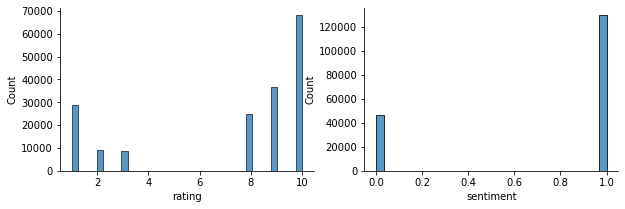

In [7]:
# rating and sentiment histogram after preprocessing
cols = ['rating', 'sentiment']
nrows, ncols = 1, 2

f, axs = plt.subplots(1, 2, figsize=(10,3))
for idx, ax in enumerate(axs):
    sns.histplot(
    data=df,
    stat="count",
    x = cols[idx],
    ax=ax
    )

    # add labels and ticks
    ax.set(xlabel=cols[idx])
    #plt.xticks(np.arange(1,11,1))
    sns.despine()

Our dataset is very imbalanced. We will correct for class imbalance by taking only 46,000 random examples from each class.

In [8]:
# randomly draw 46000 examples from each class
temp_positive = df[df.sentiment.eq(1)].sample(
    n=46000,
    replace=False
)

temp_negative = df[df.sentiment.eq(0)].sample(
    n=46000,
    replace=False
)

df_balanced = pd.concat(
    [temp_positive, temp_negative],
    axis=0)

# shuffle df_balanced
df_balanced.sample(frac=1) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data contains', df_balanced.shape[0], 'reviews.')

After preprocessing, our data contains 92000 reviews.


``Step 3: Create TensorFlow dataset and split into training, val, test``

In [9]:
df_balanced = df_balanced[['review', 'sentiment']]
df_balanced.head(5)

,review,sentiment
0,i can 039 t say enough positive things about ...,1
1,it makes you feel very energetic and makes yo...,1
2,i was prescribed diclegis by my ob for extrem...,1
3,i 039 ve been on metformin for 2 weeks now an...,1
4,makes me sleep,1


<span style="color:chocolate">create TensorFlow dataset</span> 

In [10]:
# define target
target = df_balanced.pop('sentiment') # .pop removes sentiment col from df

# target and review combined tensors
data_tf = tf.data.Dataset.from_tensor_slices(
    (df_balanced[['review']].values, target.values)
)

<span style="color:chocolate">split data into train, validation, and test partitions</span> 

In [11]:
# set random seed
tf.random.set_seed(1)

# define splits for training, validation, test
splits=[0.6, 0.2, 0.2] 

# shuffle data
data_tf = data_tf.shuffle(
    df_balanced.shape[0], reshuffle_each_iteration=False)

data_tf_test = data_tf.take(int(df_balanced.shape[0]*splits[2]))
data_tf_train_valid = data_tf.skip(int(df_balanced.shape[0]*splits[2]))
data_tf_train = data_tf_train_valid.take(int(df_balanced.shape[0]*splits[0]))
data_tf_valid = data_tf_train_valid.skip(int(df_balanced.shape[0]*splits[0]))

``Step 4: Identify unique words (tokens) in the training dataset``

In [12]:
# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# create an instance of the Counter class
token_counts = Counter()

for example in data_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Size of training vocabulary:', len(token_counts))

Size of training vocabulary: 33159


``Step 5. Encoding: sequences of words into sequences of integers``

The idea here is to map each unique word (token) in our training vocabulary to a unique integer.

In [13]:
# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

In [14]:
# the encode_map_fn is defined at the top of the notebook
data_tf_train = data_tf_train.map(encode_map_fn)
data_tf_valid = data_tf_valid.map(encode_map_fn)
data_tf_test = data_tf_test.map(encode_map_fn)

``Step 6: Divide the dataset into mini-batches as input to the model``

In [15]:
# define batch size
batch_size = 32

# batcing of training, validation and test partitions
train_data = data_tf_train.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

valid_data = data_tf_valid.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

test_data = data_tf_test.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

In [37]:
test_data

<PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

``Step 7: Create features (embeddings)``

Note: this is just a stand alone. For clarity, we will code again the Embedding layer in the network architecture.

In [16]:
# Embed our training vocabulary into 10 dimensions.
vocab_size_train = len(token_counts) + 2
embedding_dim = 10

embedding_layer = tf.keras.layers.Embedding(
    vocab_size_train,
    embedding_dim,
)

Let's pass our first example in the training dataset through our embedding layer. The result replaces each integer with the vector from the embedding table:

In [17]:
for example in train_data.take(1):
    print('Seq length of our first training example:', example[0].numpy()[0].shape[0])
    print("Print integers of example:")
    print(example[0].numpy()[0])
    result = embedding_layer(example[0])

print("\nPrint embeddings of example:")
result_df = pd.DataFrame(result[0].numpy())
display(result_df.head())
print("Embedding size:", result_df.shape)

Seq length of our first training example: 153
Print integers of example:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13  4 14  1 15 16  5 12  8 17 18 19
 20 11 17 21 22  1 23 24 25 12 13 26 17 22 11 27 28 12 29 30 13  4 31 32
  1 33  4 34 35 36  1 33 37 38 39 40 41 42  1 43 44 12  9 10 45  1 33 14
 46 47 48 49 50 49 19 20  1 51 52 53  6  7 54 55  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]

Print embeddings of example:


,0,1,2,3,4,5,6,7,8,9
0,-0.031200,0.004876,0.004892,0.004953,-0.022011,-0.039104,0.013091,0.037382,0.003226,0.006110
1,-0.020607,0.042848,-0.039026,0.046354,0.018593,-0.021850,0.029469,-0.040199,0.047610,0.033333
2,0.036092,0.016561,-0.034383,0.044283,0.030456,0.048127,0.048334,-0.045737,-0.007386,0.006110
3,-0.011646,-0.030332,-0.000456,-0.013150,-0.027652,0.014536,-0.028667,0.030626,-0.044637,-0.015272
4,0.003854,0.027384,0.003839,0.005660,-0.046386,0.021533,-0.044337,-0.039169,0.015789,-0.026284


Embedding size: (153, 10)


In [ ]:
(n_train, seq_len==100, embeddings_size)

---
## Model

Our objective is to build and train a CNN model to detect if a drug review is positive or negative.

The complete model is made of a few layers:

1. An embedding layer: converts our word tokens (integers) into embedded vectors of a specific size.

2. A few convolutional layers: defined by an input size, number of filters/feature maps to output, and a kernel size. The output of these layers will go through a ReLu activation function and a pooling layer

4. A fully-connected, output layer: maps the convoluted layer outputs to a desired output_size (1 sentiment class).

5. A sigmoid activation layer: turns the output logit into a value 0-1; a class score.


There are also a few dropout layers, which will prevent overfitting, placed between the layers of the model.


``Build model``

Since text data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.

The kernel size in the convolutional layer defines the number of words to consider as the convolution is passed across the input text, providing a grouping parameter.

Multiple convolutions with different kernel sizes allows a sentence to be processed at different n-grams (groups of words) at a time, whilst the model learns how to best integrate these interpretations.

In [34]:
vocab_size_train = len(token_counts) + 2
embedding_dim = 10

def build_model():
    ''''''
    # clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1)
    
    # define model
    model = tf.keras.Sequential()

    ## add embedding layer ##
    #########################
    # (this is our imput layer)
    # embeddings will be learned during training
    # the weights for the embeddings are randomly initialized (just like any other layer!)
    model.add(Embedding(
        vocab_size_train,
        embedding_dim,
        input_length=100, #limits length of sentence to 100 tokens
        name="embedding")
        ),

    ## first convolution ##
    #######################
    model.add(Conv1D(
        filters=128,
        kernel_size=4,
        padding='same',
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add maxpooling
    model.add(MaxPooling1D(pool_size=2))



    ## second convolution ##
    ########################
    model.add(Conv1D(
        filters=64,
        kernel_size=4,
        padding='same',
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add maxpooling
    model.add(MaxPooling1D(pool_size=2))

    ## third convolution ##
    #######################
    model.add(Conv1D(
        filters=32,
        kernel_size=5,
        padding='same',
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    # add maxpooling
    model.add(MaxPooling1D(pool_size=2))

    ## average embeddings ##
    ########################
    model.add(GlobalAveragePooling1D()),

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5))



    ## add final dense (output) layer ##
    ####################################
    model.add(Dense(1, activation='sigmoid'))

    # save embeddings before training 
    embeddings_untrained = model.get_layer('embedding').get_weights()[0]

    # print model summary
    model.summary()
    
    return model, embeddings_untrained


model, embeddings_untrained = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 10)           331610    
                                                                 
 conv1d (Conv1D)             (None, 100, 128)          5248      
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            32832     
                                                                 
 dropout_1 (Dropout)         (None, 50, 64)            0         
                                                        

``Compile model``

In [35]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

``Fit model``

In [36]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1)
np.random.seed(1)
history = model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=5)

Epoch 1/5
1725/1725 [==============================] - 63s 36ms/step - loss: 0.4215 - accuracy: 0.8084 - val_loss: 0.3776 - val_accuracy: 0.8666
Epoch 2/5
1725/1725 [==============================] - 71s 41ms/step - loss: 0.2896 - accuracy: 0.8888 - val_loss: 0.3331 - val_accuracy: 0.8822
Epoch 3/5
1725/1725 [==============================] - 68s 39ms/step - loss: 0.2347 - accuracy: 0.9120 - val_loss: 0.3319 - val_accuracy: 0.8795
Epoch 4/5
1725/1725 [==============================] - 70s 41ms/step - loss: 0.1951 - accuracy: 0.9291 - val_loss: 0.3013 - val_accuracy: 0.8884
Epoch 5/5
1725/1725 [==============================] - 70s 40ms/step - loss: 0.1650 - accuracy: 0.9409 - val_loss: 0.3003 - val_accuracy: 0.8879


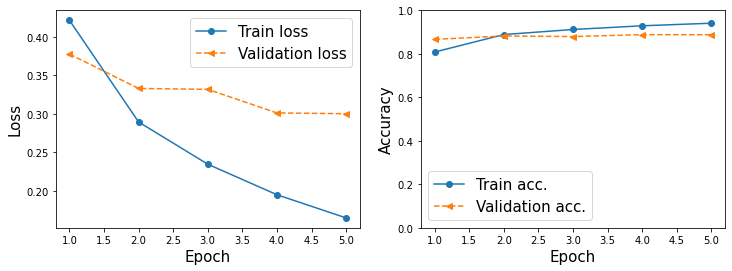

In [33]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

In [22]:
print('After training this model for 5 epochs, evaluation on the validation data shows an accuracy of:')
print(np.round(hist['val_accuracy'][-1]*100,2), '%')

After training this model for 5 epochs, evaluation on the validation data shows an accuracy of:
89.05 %


---
## Inspecting Learned Embeddings

Next, retrieve the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape (vocab_size_train, embedding_dim). 

We will obtain the weights from the model using `get_layer()` and `get_weights()`. 

In [23]:
# retrieve embeddings after training (weights)
embeddings_trained = model.get_layer('embedding').get_weights()[0]

# remove embedings at index 0 and last index
# these correspond to the additional indeces added for padding (0) and out of vocabulary words (size_train_vocab + 1).
embeddings_trained = embeddings_trained[1:-1]
embeddings_untrained = embeddings_untrained[1:-1] # for untrained too

# retrieve vocabulary
train_vocab = []
for token in token_counts.keys():
    train_vocab.append(token)
print('Size of trained embeding matrix:', embeddings_trained.shape)
print('Size of training vocabulary:', len(token_counts))

Size of trained embeding matrix: (33159, 10)
Size of training vocabulary: 33159


For word (token) at index 3 in vocabulary print the untrained and trained embeddings:

In [24]:
print('Word at index 3 in train vocab is:', train_vocab[3])
temp_df = pd.DataFrame({'untrained':embeddings_untrained[4], 'trained': embeddings_trained[4]}).T
print('Print embeddings:')
display(temp_df)

Word at index 3 in train vocab is: been
Print embeddings:


,0,1,2,3,4,5,6,7,8,9
untrained,-0.011810,0.022555,-0.001849,0.004458,-0.046391,-0.038309,0.031844,0.036212,0.047907,-0.008757
trained,0.015379,-0.023410,0.010758,-0.010957,-0.007845,-0.030575,0.003801,0.041746,0.037323,0.106717


``apply PCA to reduce embeddings to 2D``

In [25]:
# create an instance of the PCA class
pca = PCA(n_components=2) # PCA imported from sklearn.decomposition

# fit the data using the original X_train_std data; tranform X_train_std data
embeddings_trained_pca = pca.fit_transform(embeddings_trained)

# visualize
display(pd.DataFrame(embeddings_trained_pca).head())

,0,1
0,0.038435,-0.061569
1,-0.051265,-0.125951
2,-0.018377,-0.173875
3,-0.045345,-0.088044
4,-0.065234,-0.145736


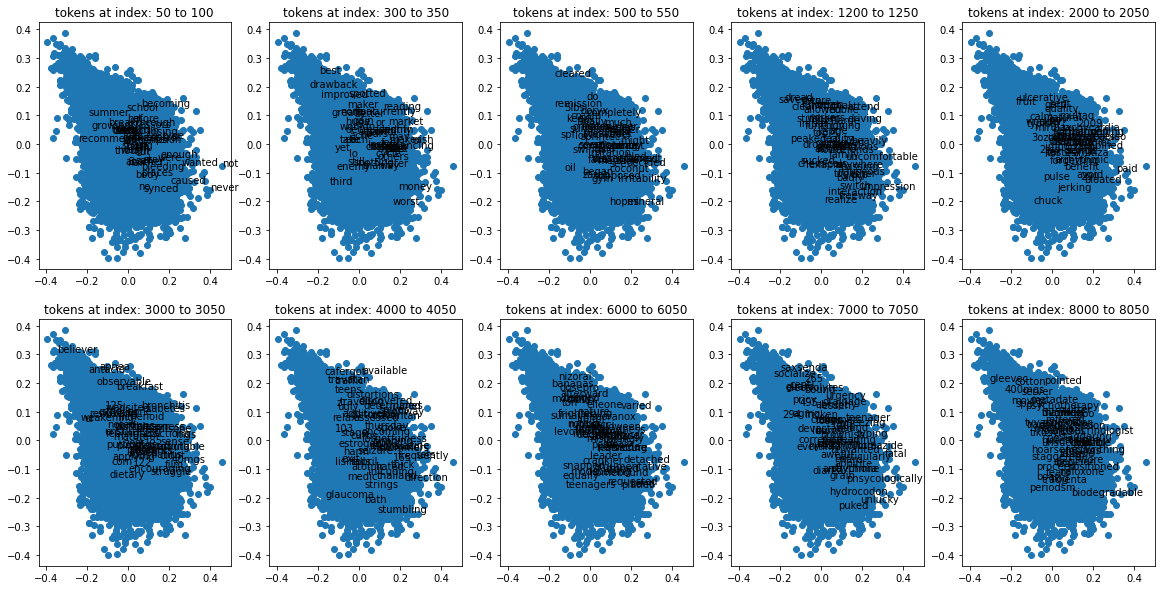

In [26]:
nrows, ncols = 2,5 
partitions_min = [50, 300,  500, 1200, 2000, 3000, 4000, 6000, 7000, 8000]
partitions_max = [100, 350, 550, 1250, 2050, 3050, 4050, 6050, 7050, 8050]
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))

for idx, ax in enumerate(axs.flatten()):
    ax.scatter(
        embeddings_trained[:,0],
        embeddings_trained[:,1]
    )
    
    for i, token in enumerate(train_vocab):
        if i >= partitions_min[idx] and i <= partitions_max[idx]:
            ax.annotate(token, (embeddings_trained[i][0:2]))
            ax.set_title('tokens at index: ' + str(partitions_min[idx]) + ' to ' + str(partitions_max[idx]))





---
## Evaluation

let's look at only one example in the test data:

In [27]:
test_results = model.evaluate(test_data)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

575/575 [==============================] - 8s 14ms/step - loss: 0.2913 - accuracy: 0.8887

Test Acc. 88.87%


In [28]:
# predict probabilities
predictions = model.predict(test_data)

for ex in test_data.take(1):
    print('Printing encoded example:')
    print('-------------------------')
    print(ex[0].numpy()[0]) # test data is a mini-batch, keep only the first example in the first batch
    
    print('\nPrinting decoded example:')
    print('-------------------------')
    print(encoder.decode(ex[0].numpy()[0]))
    
    print('\nPrinting prediction of example:')
    print('-------------------------------')
    if predictions[0] < 0.5:
        print('Negative drug review with probability of positive class:', predictions[0]*100)
    else:
        print('Positive drug review with probability of positive class:', predictions[0]*100)

Printing encoded example:
-------------------------
[    1    43    44  6887   186  1406    10    45    17   118   213    56
    82   101   272   186  3011  2243    12  4378    12    59  5145  5144
    32    17   118  1876  5556    59  5576     1    56    52  5141  1541
    44 33160    17  4438    56   798   733     1   233   103   113 33160
    11    17   118  6580   233    59  5385   293    38   187     1   214
  2378    17  5141  1574   375   302   741    38    48    59   146     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0